# Predicting a exponentially decacying noisy sine function with overlapping periods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, Bidirectional

import random
from random import seed, random
from sklearn.utils import shuffle

%matplotlib inline

/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Simulate data
cycle = 100
step = 0.1
noise = 0.1 # standard deviation from 0
decaying_coef = 0.00

end_pt = 2 * np.pi * cycle
t = np.arange(0, end_pt, step)
a = np.sin(t) #* np.sin(0.5 * t) * np.sin(0.2 * t) * np.sin(0.3 * t) * np.sin(2 * t)
a_noisy = a + np.random.normal(0, noise, a.size)
a_decaying = a_noisy * np.exp(-decaying_coef * t)
data = a_decaying

# Note: If noise is not modulated by the exponential function, it will overwhelm the signal near the end of the data sequence
# which is where test data is picked from. We can modulate it in simulated environment but in experiments, we may have to discard
# data near the end of the motion.

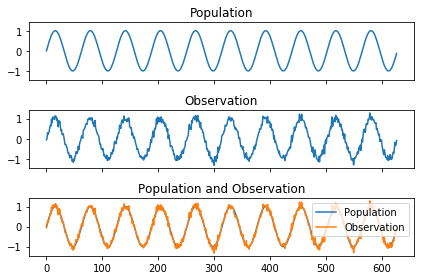

In [3]:
# visualize data
n_plot = int(a.size/10)

_, axarr = plt.subplots(3, sharex=True, sharey=True)
axarr[0].plot(a[:n_plot])
axarr[0].set_title('Population')
axarr[1].plot(a_decaying[:n_plot])
axarr[1].set_title('Observation')
axarr[2].plot(a[:n_plot], label="Population")
axarr[2].plot(a_decaying[:n_plot], label="Observation")
axarr[2].set_title('Population and Observation')
axarr[2].legend()
plt.tight_layout()
plt.show()

In [4]:
# hyperparameters
DATA_DIM = 1
N_PREV = 50 # number of previous steps used to predict the next step

In [5]:
def _load_data(data, n_prev=N_PREV, is_shuffled=False):
    docX, docY = [], []
    for j in range(len(data)-n_prev):
        docX.append(data[j:j+n_prev])
        docY.append(data[j+n_prev])   
    alsX = np.array(docX)
    alsY = np.array(docY)
    if is_shuffled: 
        alsX, alsY = shuffle(alsX, alsY)

    return alsX.reshape(alsX.shape[0], alsX.shape[1], DATA_DIM), alsY.reshape(alsY.shape[0], DATA_DIM)

def train_test_split(data, test_size=0.6):  
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(data) * (1 - test_size)))

    X_train, y_train = _load_data(data[0:ntrn], is_shuffled=True)
    X_test, y_test = _load_data(data[ntrn:])

    return (X_train, y_train), (X_test, y_test)


# retrieve data
(X_train, y_train), (X_test, y_test) = train_test_split(data)

In [6]:
# define model structure
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=False), input_shape=(None, 1)))
# model.add(Bidirectional(CuDNNLSTM(units=5, return_sequences=False)))
# model.add(Bidirectional(CuDNNLSTM(units=3, return_sequences=False)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=False)))
# model.add(Dense(units=10, activation="selu"))
model.add(Dense(units=1, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")

In [7]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.1)

Train on 2217 samples, validate on 247 samples
Epoch 1/20


InternalError: Failed to create session.

In [ ]:
print(history.history.keys())
print(len(history.history['val_loss']))
# summarize history for loss
plt.plot(history.history['loss'][-30:])
plt.plot(history.history['val_loss'][-30:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# evaluate model fit
score = model.evaluate(X_test, y_test)
print('Test score:', score)

In [ ]:
# perform modelling
X_model = X_test[0]
modelled_data = []
dims = 1, X_model.shape[0], X_model.shape[1]
for i in range(len(y_test)):
    prev_steps = X_model.reshape(*dims)
    next_step = model.predict(prev_steps)
    modelled_data.append(list(next_step[0]))
    X_model = np.append(X_model[1:], next_step)

# evaluate
print(np.mean((modelled_data[:len(y_test)]-y_test)**2))

In [ ]:
plt.figure(figsize=(20,10))
# plt.plot(y_test[:], label='test_data')
plt.plot(modelled_data[:1000], label='test_model')
plt.title('Test Observation and Prediction')
plt.legend()

In [ ]:
# visualize predictions
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

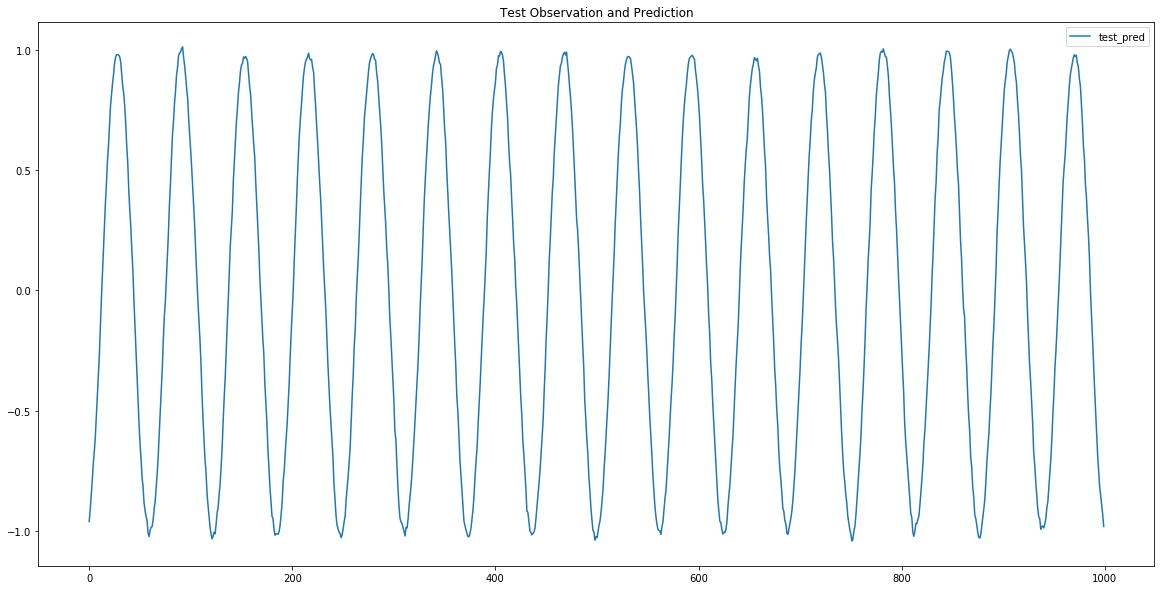

In [1196]:
plt.figure(figsize=(20,10))
# plt.plot(y_test[:], label='test_data')
plt.plot(test_prediction[:1000], label='test_pred')
plt.title('Test Observation and Prediction')
plt.legend()

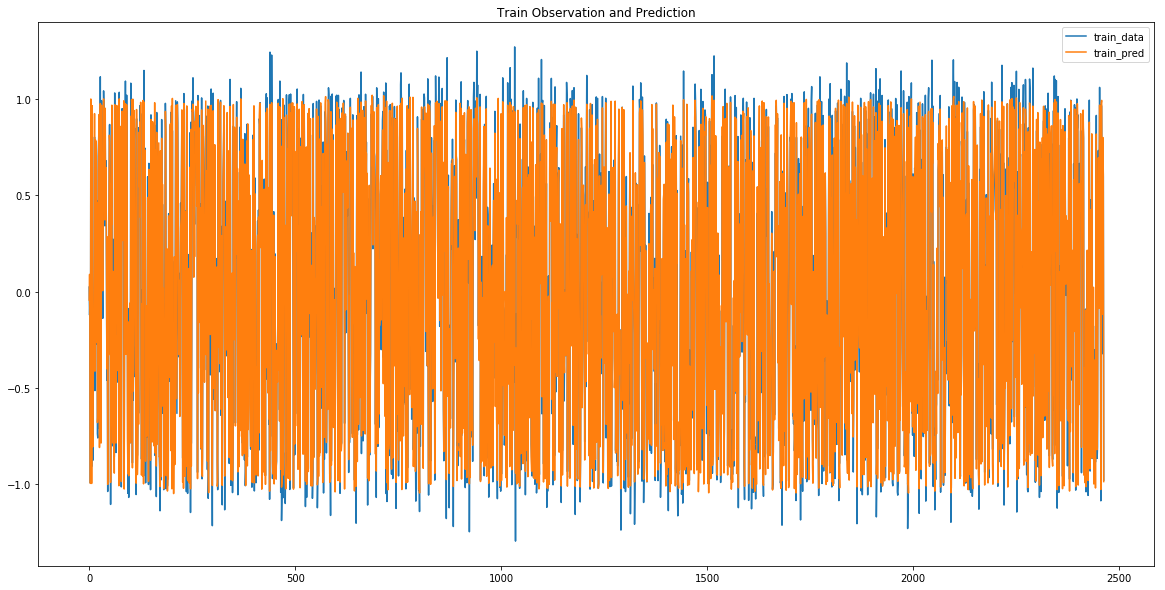

In [1189]:
plt.figure(figsize=(20,10))
plt.plot(y_train[0:], label='train_data')
plt.plot(train_prediction[0:], label='train_pred')
plt.title('Train Observation and Prediction')
plt.legend()